# Chord Analysis


In [19]:
import music21
import os
import sys
sys.path.append('../scripts')

import utils

from constants import GUITAR_INSTRUMENT_PATCH_NUMBERS, TUNING_LABELS

## Create dictionaries for analysis files and music21 scores 

In [2]:
"""
Create a id:score map and id:analysis map
So we can easily look at both together with the same id
"""
analysis_map = {}
score_map = {}

total_files = 0
for root, dirs, files in os.walk("../dataset-converted-xml/"):
    for file in files:
        if file.endswith(".musicxml"):
            # Construct the full path to the file
            full_path = os.path.join(root, file)            
            identifier = utils.get_id_from_path(full_path)
            score = music21.converter.parse(full_path)
            score_map[identifier] = score
            analysis_map[identifier] = utils.lookup_analysis_for_file(full_path)
            total_files+=1
print("total files retrieved", total_files)

No analysis found for Open D/Metal/Slaughter - Old Man.
No analysis found for Open D/Pop/Susanne Sundfør - Gravity.
No analysis found for Open D/Pop/Tamino - Verses.
No analysis found for Drop D/Folk/Hannes Wader - Heute Hier Morgen Dort.
No analysis found for Drop D/Folk/Alexi Murdoch - All My Days.
No analysis found for Drop D/Folk/Richard Thompson - Beeswing.
No analysis found for Drop D/Folk/Misc Traditional - Spatter The Dew.
No analysis found for Drop D/Metal/Opeth - Porcelain Heart (ver 2 by xFilth).
No analysis found for Drop D/Blues/Hugh Laurie - The Firing Song.


/home/am/Documents/upf_smc/yr1/amplab/ug-dataset/.venv/lib/python3.11/site-packages/music21/musicxml/xmlToM21.py:2206: MusicXMLWarning: Warning: measure 17 in part Rythmis overfull: 493/120 > 4.0,assuming 4.0 is correct.
  warnings.warn(
/home/am/Documents/upf_smc/yr1/amplab/ug-dataset/.venv/lib/python3.11/site-packages/music21/musicxml/xmlToM21.py:2206: MusicXMLWarning: Warning: measure 7 in part Leadis overfull: 2141/480 > 4.0,assuming 4.0 is correct.
  warnings.warn(
/home/am/Documents/upf_smc/yr1/amplab/ug-dataset/.venv/lib/python3.11/site-packages/music21/musicxml/xmlToM21.py:2206: MusicXMLWarning: Warning: measure 13 in part Leadis overfull: 331/80 > 4.0,assuming 4.0 is correct.
  warnings.warn(
/home/am/Documents/upf_smc/yr1/amplab/ug-dataset/.venv/lib/python3.11/site-packages/music21/musicxml/xmlToM21.py:2206: MusicXMLWarning: Warning: measure 15 in part Leadis overfull: 2141/480 > 4.0,assuming 4.0 is correct.
  warnings.warn(
/home/am/Documents/upf_smc/yr1/amplab/ug-dataset/.v

No analysis found for Drop D/Blues/Joseph Spence - Glory Glory.
No analysis found for Drop D/Blues/Eric Bibb - Needed Time.
No analysis found for Drop D/Blues/Rory Block - Big Road Blues.
No analysis found for Drop D/Blues/B.B. King - Get Out Of My Back Woman.
No analysis found for Drop D/Pop/Bruno Mars - Just The Way You Are (ver 3 by Mr. Heater).
No analysis found for Drop D/Pop/Jason Mraz - I Wont Give Up.
No analysis found for Drop D/Jazz/Sarah Vaughan - My Favorite Things.
No analysis found for Drop D/Jazz/Duke Ellington - Drop Me Off In Harlem.
No analysis found for Drop D/Jazz/Pat Metheny - American Garage.
No analysis found for Drop D/Jazz/George Gershwin - I Loves You Porgy.
No analysis found for Drop D/Jazz/Miles Davis - All Blues (ver 3 by krassalexx).
No analysis found for Standard/Rock/Queen - Bohemian Rhapsody.
No analysis found for Standard/Rock/Lynyrd Skynyrd - Sweet Home Alabama.
No analysis found for Standard/Rock/Pink Floyd - Comfortably Numb.
No analysis found for S

## Get the score parts for a target tuning based on the scores and analysis maps

In [ ]:
def get_score_parts_with_target_tuning(target_tuning, score_map, analysis_map):
    """
    Get all parts with the target tuning
    """
    parts_with_target_tuning = []

    for identifier, score in score_map.items():
        analysis = analysis_map[identifier]

        if analysis is None:
            # print("no analysis found for", identifier)
            continue

        for part in score.parts:
            for track in analysis["tracks"]:
                if tuple(track["tuning"]) == target_tuning and part.partName == track["name"] and track["instrument"] in GUITAR_INSTRUMENT_PATCH_NUMBERS:
                    # print("found guitar track", track["tuning"], track["instrument"])
                    parts_with_target_tuning.append(part)

    return parts_with_target_tuning

### Get the score parts for a specific tuning for each of the tuning tupes into a dict

In [68]:
tuning_parts_dict = {}

# Loop through each tuning label
for tuning_name, tuning_values in TUNING_LABELS.items():
  # Get the parts with the target tuning
  parts = get_score_parts_with_target_tuning(tuning_values, score_map, analysis_map)
  # Store the parts in the dictionary
  tuning_parts_dict[tuning_name] = parts

# Print the number of parts found for each tuning
for tuning_name, parts in tuning_parts_dict.items():
  print(f"Tuning: {tuning_name}, Number of parts: {len(parts)}")

Tuning: Standard, Number of parts: 156
Tuning: Drop D, Number of parts: 97
Tuning: Open D, Number of parts: 51
Tuning: Drop C, Number of parts: 57


## Get the chord changes

In [ ]:
import matplotlib.pyplot as plt
from collections import defaultdict

def get_chord_changes(parts_with_target_guitar):
    """
    Get the frequency dict of chord changes by commonName
    """
    # Initialize a dictionary to store the count of chord changes by voice
    chord_changes = defaultdict(int)

    # Iterate through each part and count the chord changes
    for part in parts_with_target_guitar:
        last_chord_signature = None

        for element in part.flat.notes:
            if isinstance(element, music21.chord.Chord):
                current_signature = (tuple(element.normalOrder), element.bass().nameWithOctave)

                if current_signature != last_chord_signature:
                    name = element.commonName or element.commonName or "Unknown"
                    chord_changes[name] += 1
                    last_chord_signature = current_signature

    return chord_changes

def plot_top_n_chord_changes(chord_changes, n=10):
    topn = sorted(chord_changes.items(), key=lambda x: x[1], reverse=True)[:n]
    chord_names = [item[0] for item in topn]
    counts = [item[1] for item in topn]

    plt.figure(figsize=(10, 5))
    bars = plt.bar(chord_names, counts, color='skyblue', edgecolor='black')
    plt.xticks(rotation=45, ha='right')
    plt.title('Top 10 Chord Changes by Pitched Chord Name')
    plt.xlabel('Chord Name')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.6)

    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height + 0.1, str(height),
                ha='center', va='bottom', fontsize=9)

    plt.show()

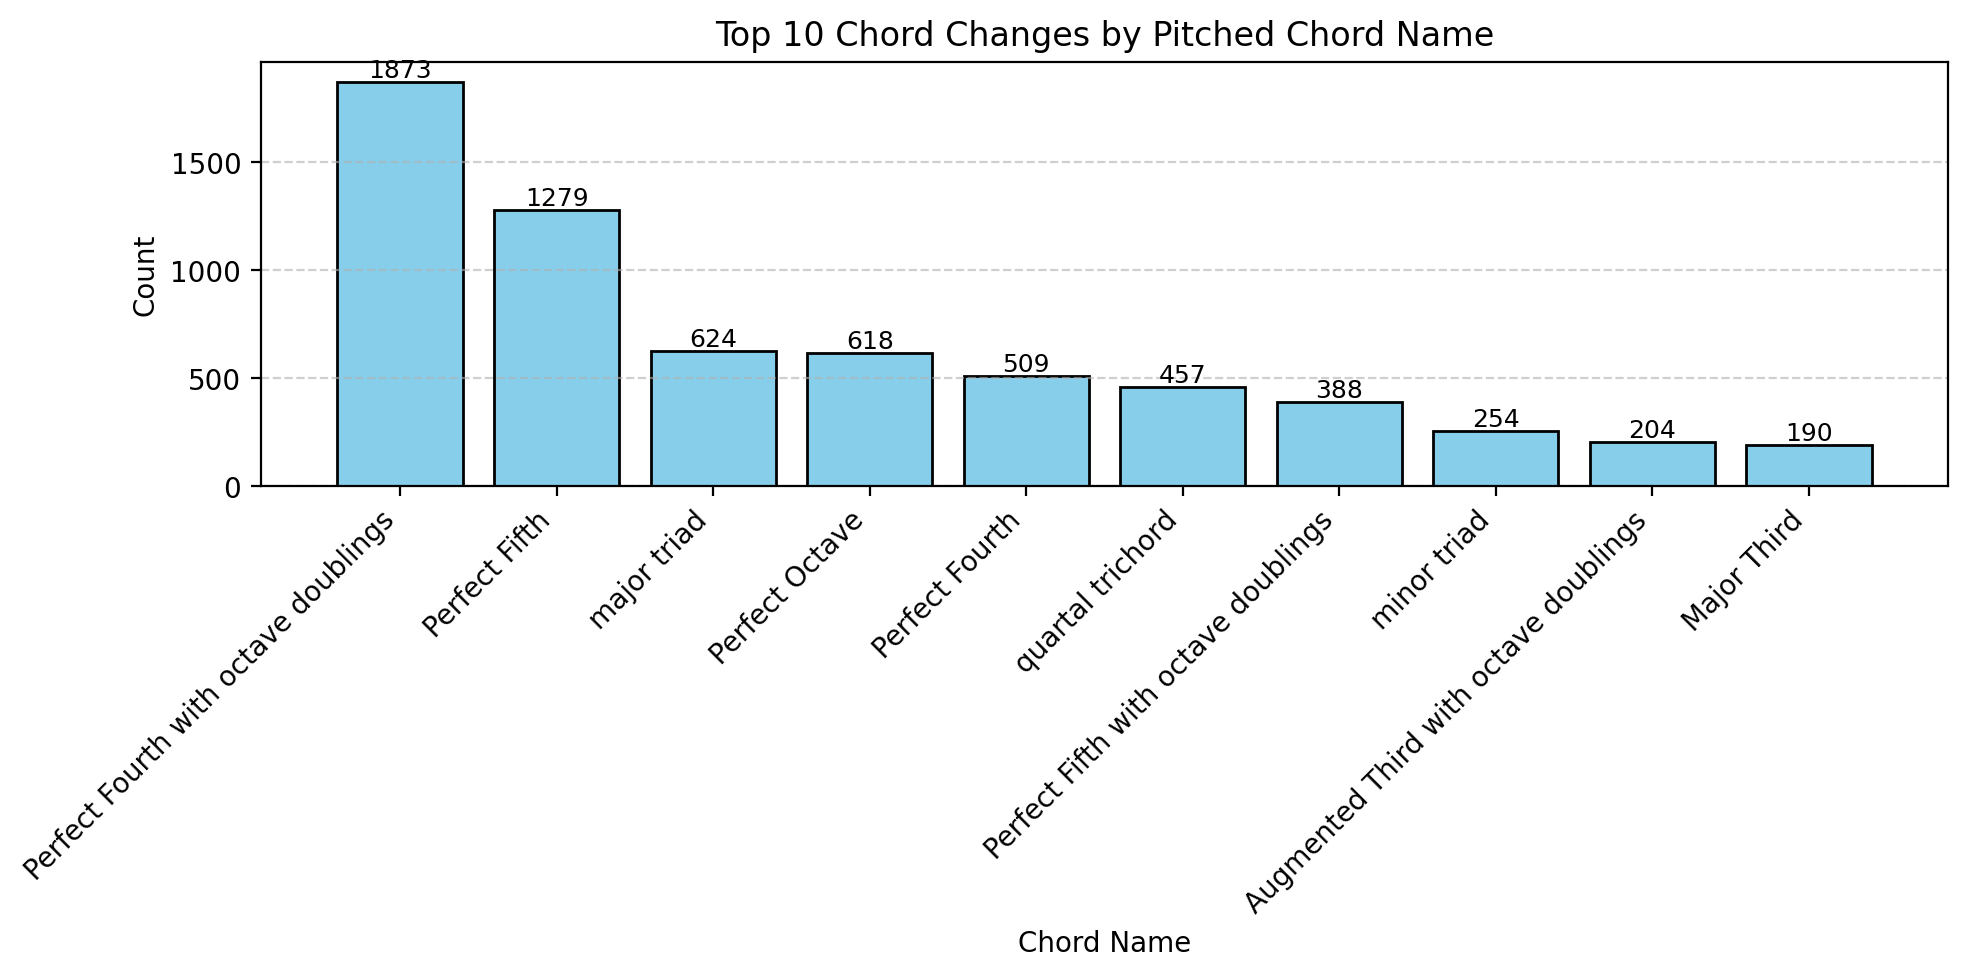

In [ ]:
plot_top_n_chord_changes(get_chord_changes(tuning_parts_dict["Drop D"]))

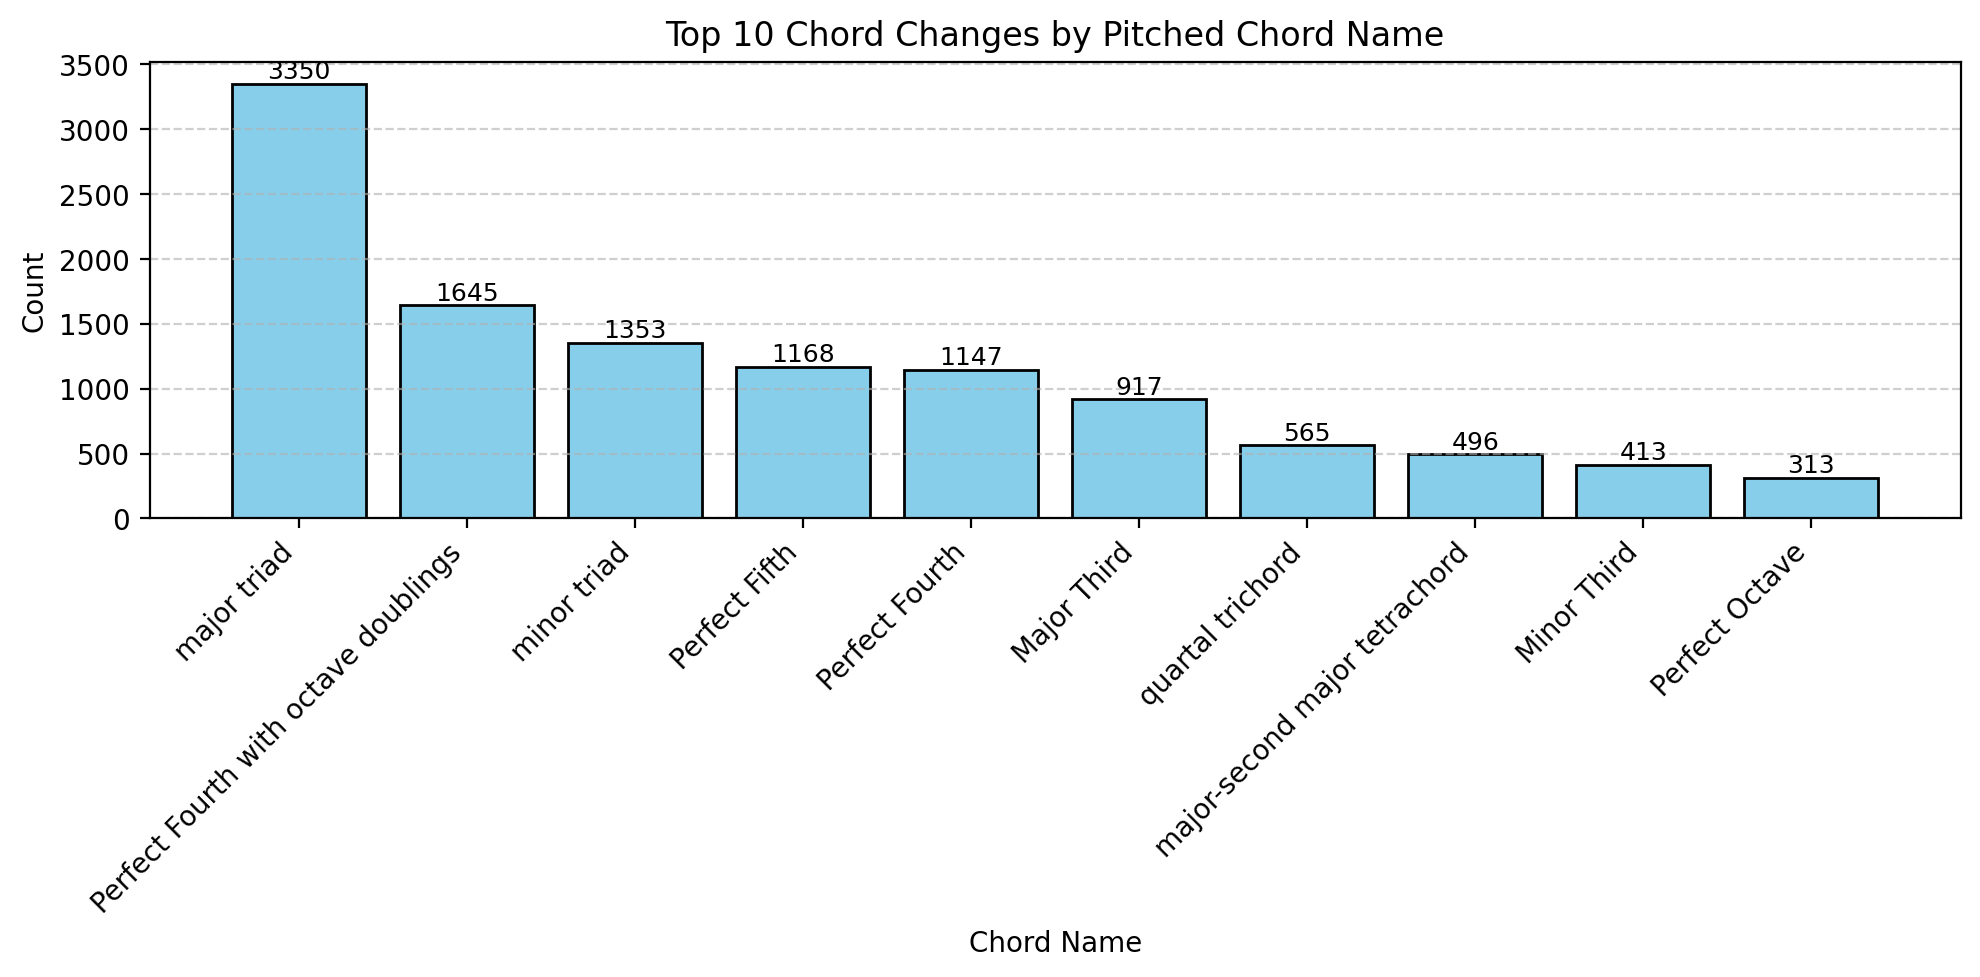

In [84]:
plot_top_n_chord_changes(get_chord_changes(tuning_parts_dict["Standard"]))


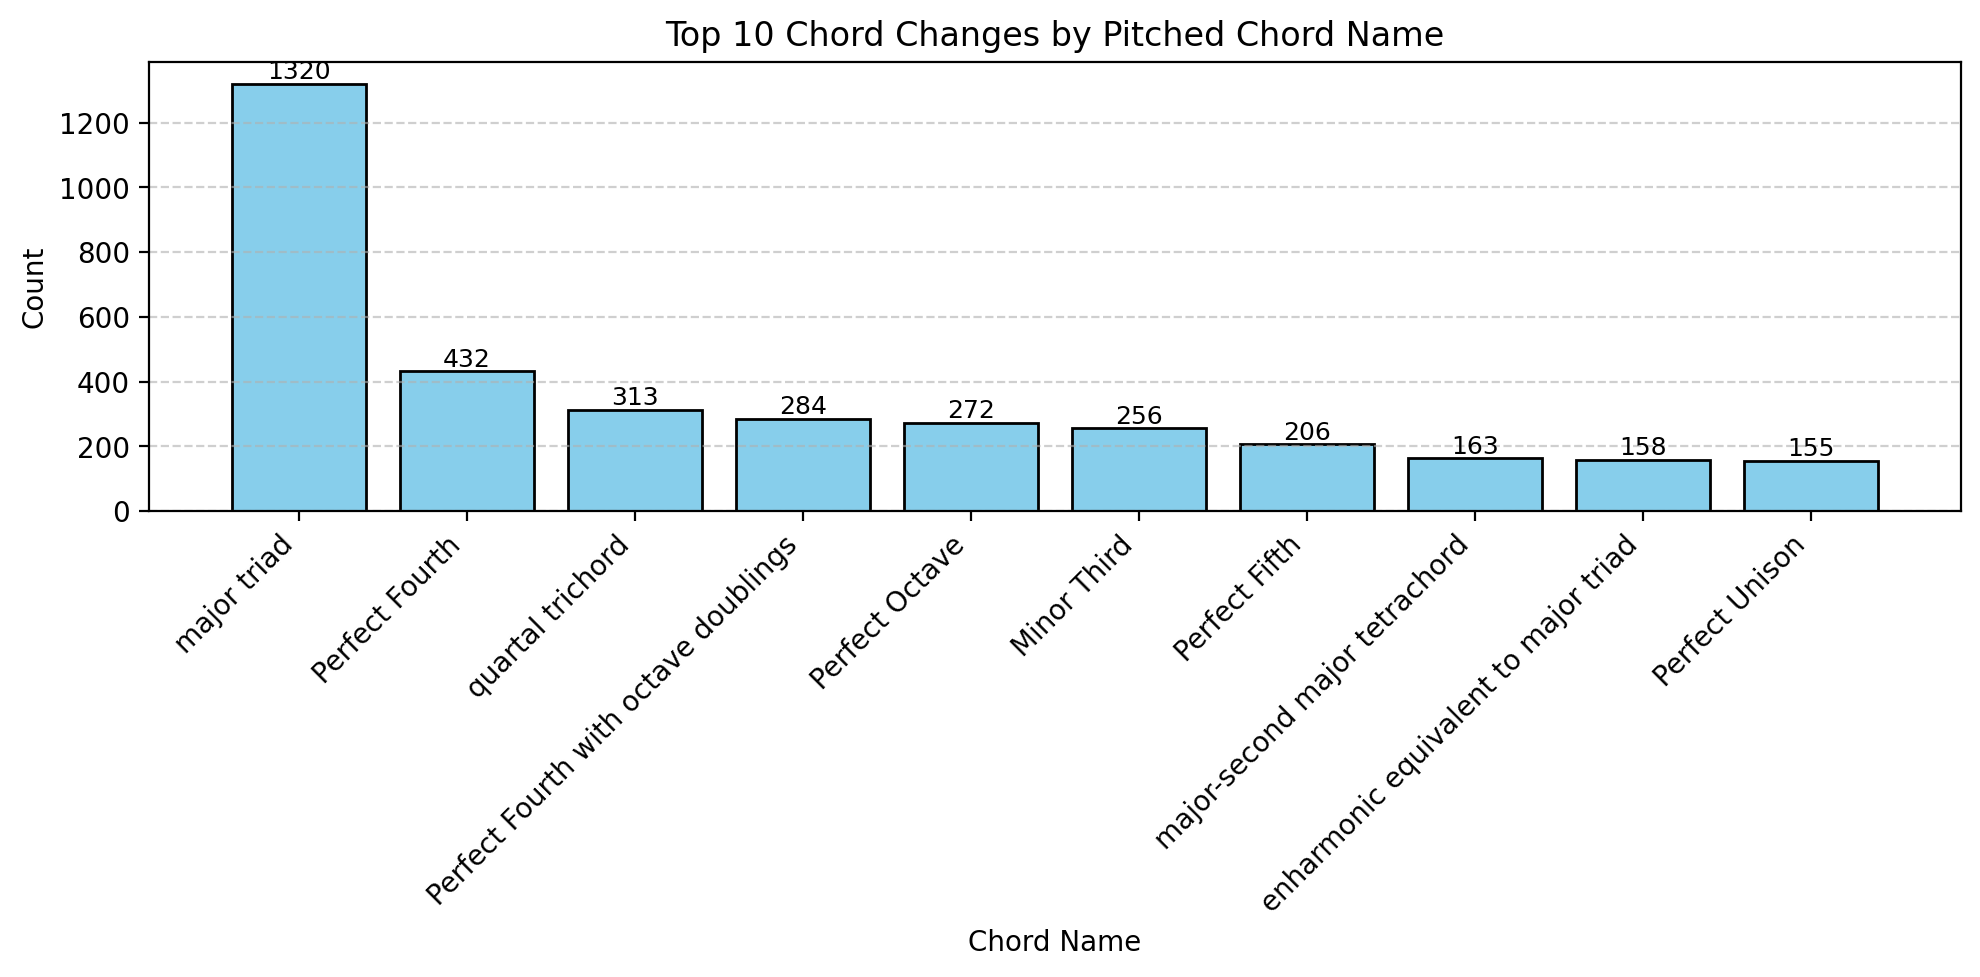

In [80]:
plot_top_n_chord_changes(get_chord_changes(tuning_parts_dict["Open D"]))

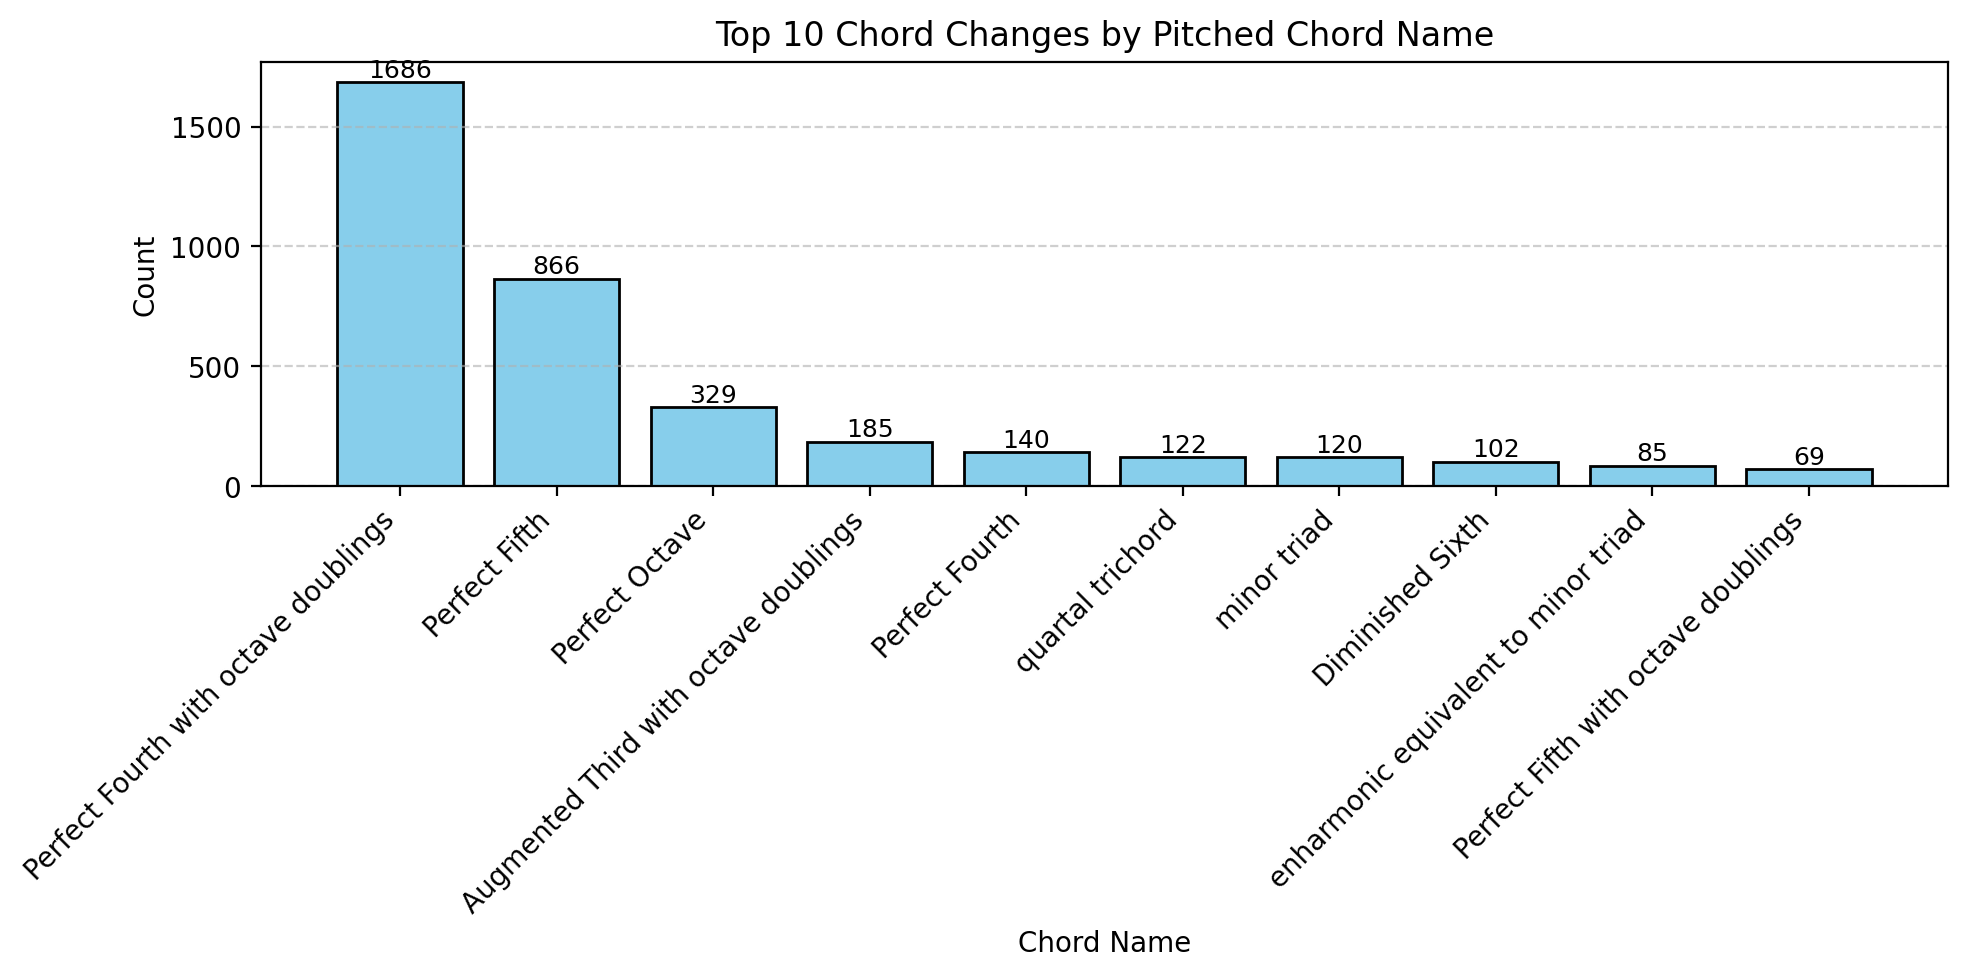

In [81]:
plot_top_n_chord_changes(get_chord_changes(tuning_parts_dict["Drop C"]))


In [ ]:
import pandas as pd

# Get top n chord changes sorted by count
topn = sorted(get_chord_changes(tuning_parts_dict["Drop C"]).items(), key=lambda x: x[1], reverse=True)[:10]

# Create and display a table using pandas
df = pd.DataFrame(topn, columns=["Chord Name", "Count"])
print(df.to_string(index=False))

/home/am/Documents/upf_smc/yr1/amplab/ug-dataset/.venv/lib/python3.11/site-packages/music21/stream/base.py:3675: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)


                           Chord Name  Count
 Perfect Fourth with octave doublings   1686
                        Perfect Fifth    866
                       Perfect Octave    329
Augmented Third with octave doublings    185
                       Perfect Fourth    140
                     quartal trichord    122
                          minor triad    120
                     Diminished Sixth    102
 enharmonic equivalent to minor triad     85
  Perfect Fifth with octave doublings     69
